# Project : **Finding Lane Lines on the Road** 

# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import cv2
import os, glob
import math
from sklearn import linear_model
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def read_img(img_path):
    return mpimg.imread(img_path)

def show_images(images, cmap=None):
    cols = 2
    rows = (len(images) + 1)//cols
    
    plt.figure(figsize=(10,11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    
    plt.show()
    
    

def save_images(images,name):
    return plt.savefig("/test_images_output"+ name,images,cmap=None)

# Read an image

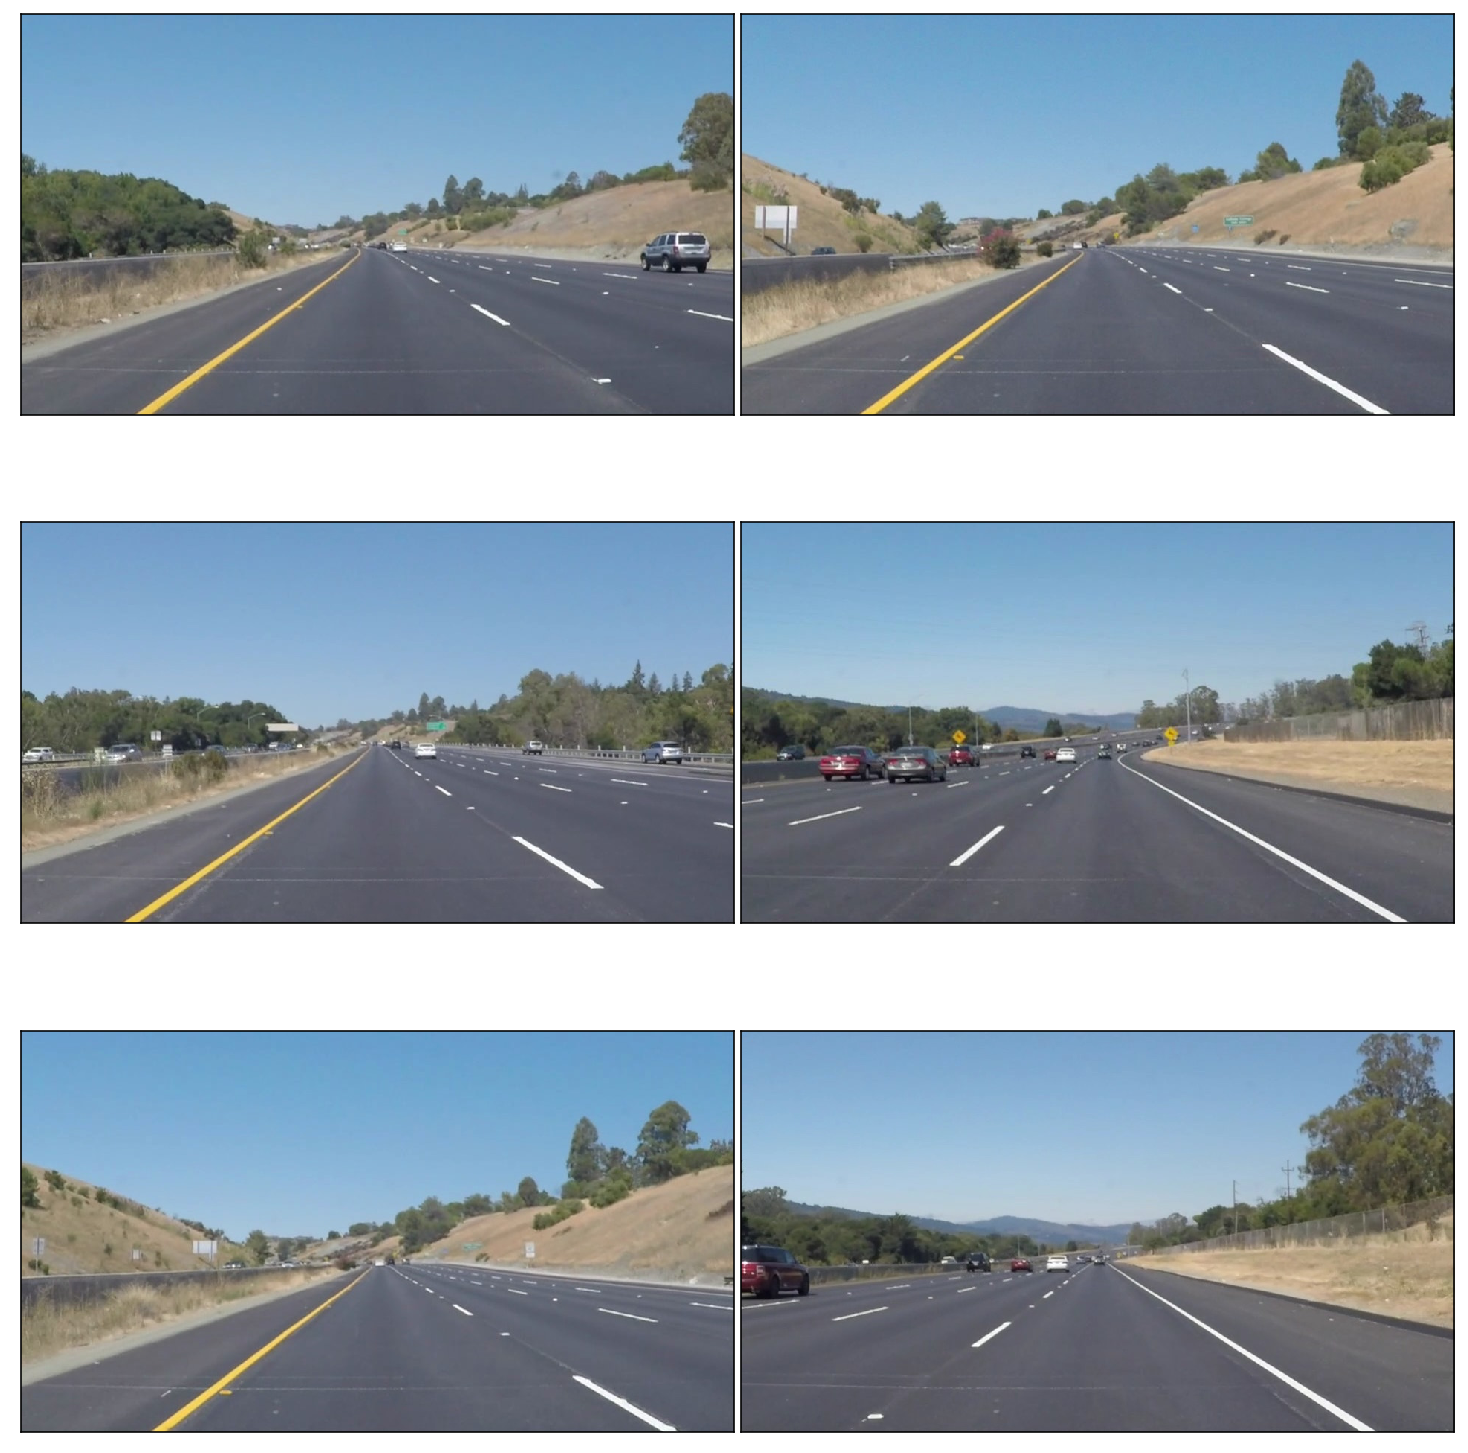

In [3]:
timg = [read_img("test_images/" + i) for i in os.listdir("test_images/")]
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
show_images(test_images)

# Lane Detection Pipeline

In [4]:
def hsl_image(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

def convert_gray_scale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def filter_color(img):
    converted = hsl_image(img)
    w_min =np.uint8([0,200,0])
    w_max = np.uint8([255,255,255])
    w_mask = cv2.inRange(converted,w_min,w_max)
    y_min =np.uint8([10,0,100])
    y_max = np.uint8([40,255,255])
    y_mask = cv2.inRange(converted,y_min,y_max)
    
    masked = cv2.bitwise_or(w_mask,y_mask)
    
    image = cv2.bitwise_and(img,img,mask=masked)
    return image

def apply_smoothing(img, kernel_size=15):
    """
    size of the kernel must be positie and odd
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

def average_slope_intercept(lines):
    left_lines=[]
    right_lines=[]
    left_line_weights=[]
    right_line_weights=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2==x1:
                continue
            slope = (y2-y1)/(x2-x1)
            intercept =y1 - slope * x1
            length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            
            if slope < 0:
                left_lines.append((slope,intercept))
                left_line_weights.append((length))
            else:
                right_lines.append((slope,intercept))
                right_line_weights.append((length))
    
    left_lane = np.dot(left_line_weights,left_lines) /np.sum(left_line_weights) if len(left_line_weights) > 0 else None
    right_lane = np.dot(right_line_weights,right_lines) /np.sum(right_line_weights) if len(right_line_weights) > 0 else None
    
    
    return left_lane,right_lane

def convert_line_to_points(y1,y2,line):
    if line is None:
        return None
    
    slope,intercept = line
    
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1,y1) , (x2,y2))

def lanes(image,lines):
    left_lane,right_lane = average_slope_intercept(lines)
    y1=image.shape[0]
    y2=y1 * 0.65
    
    left_line = convert_line_to_points(y1,y2,left_lane)
    right_line = convert_line_to_points(y1,y2,right_lane)
    
    return left_line,right_line


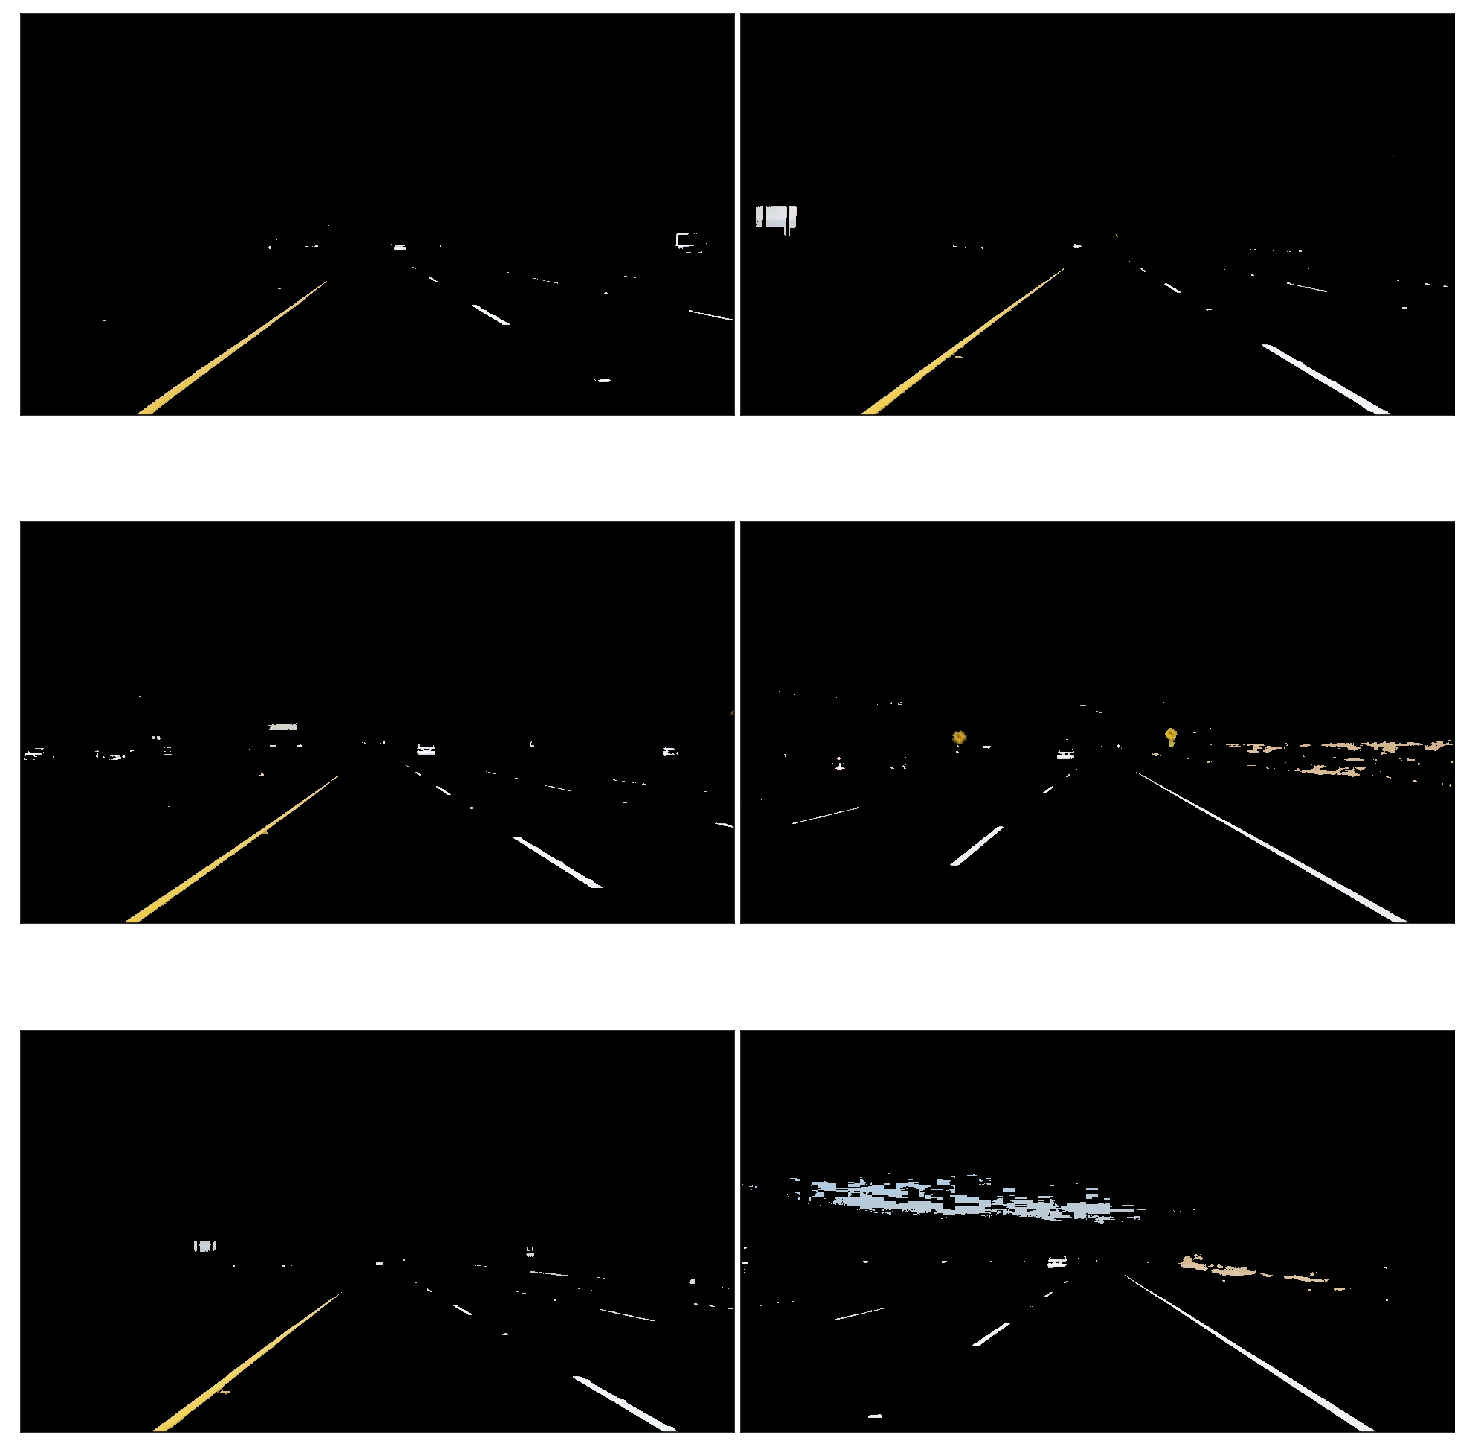

In [27]:
w_y=filter_color(timg[0])
white_yellow_filter = list(map(filter_color,test_images))
show_images(white_yellow_filter)

# Convert To Gray scale

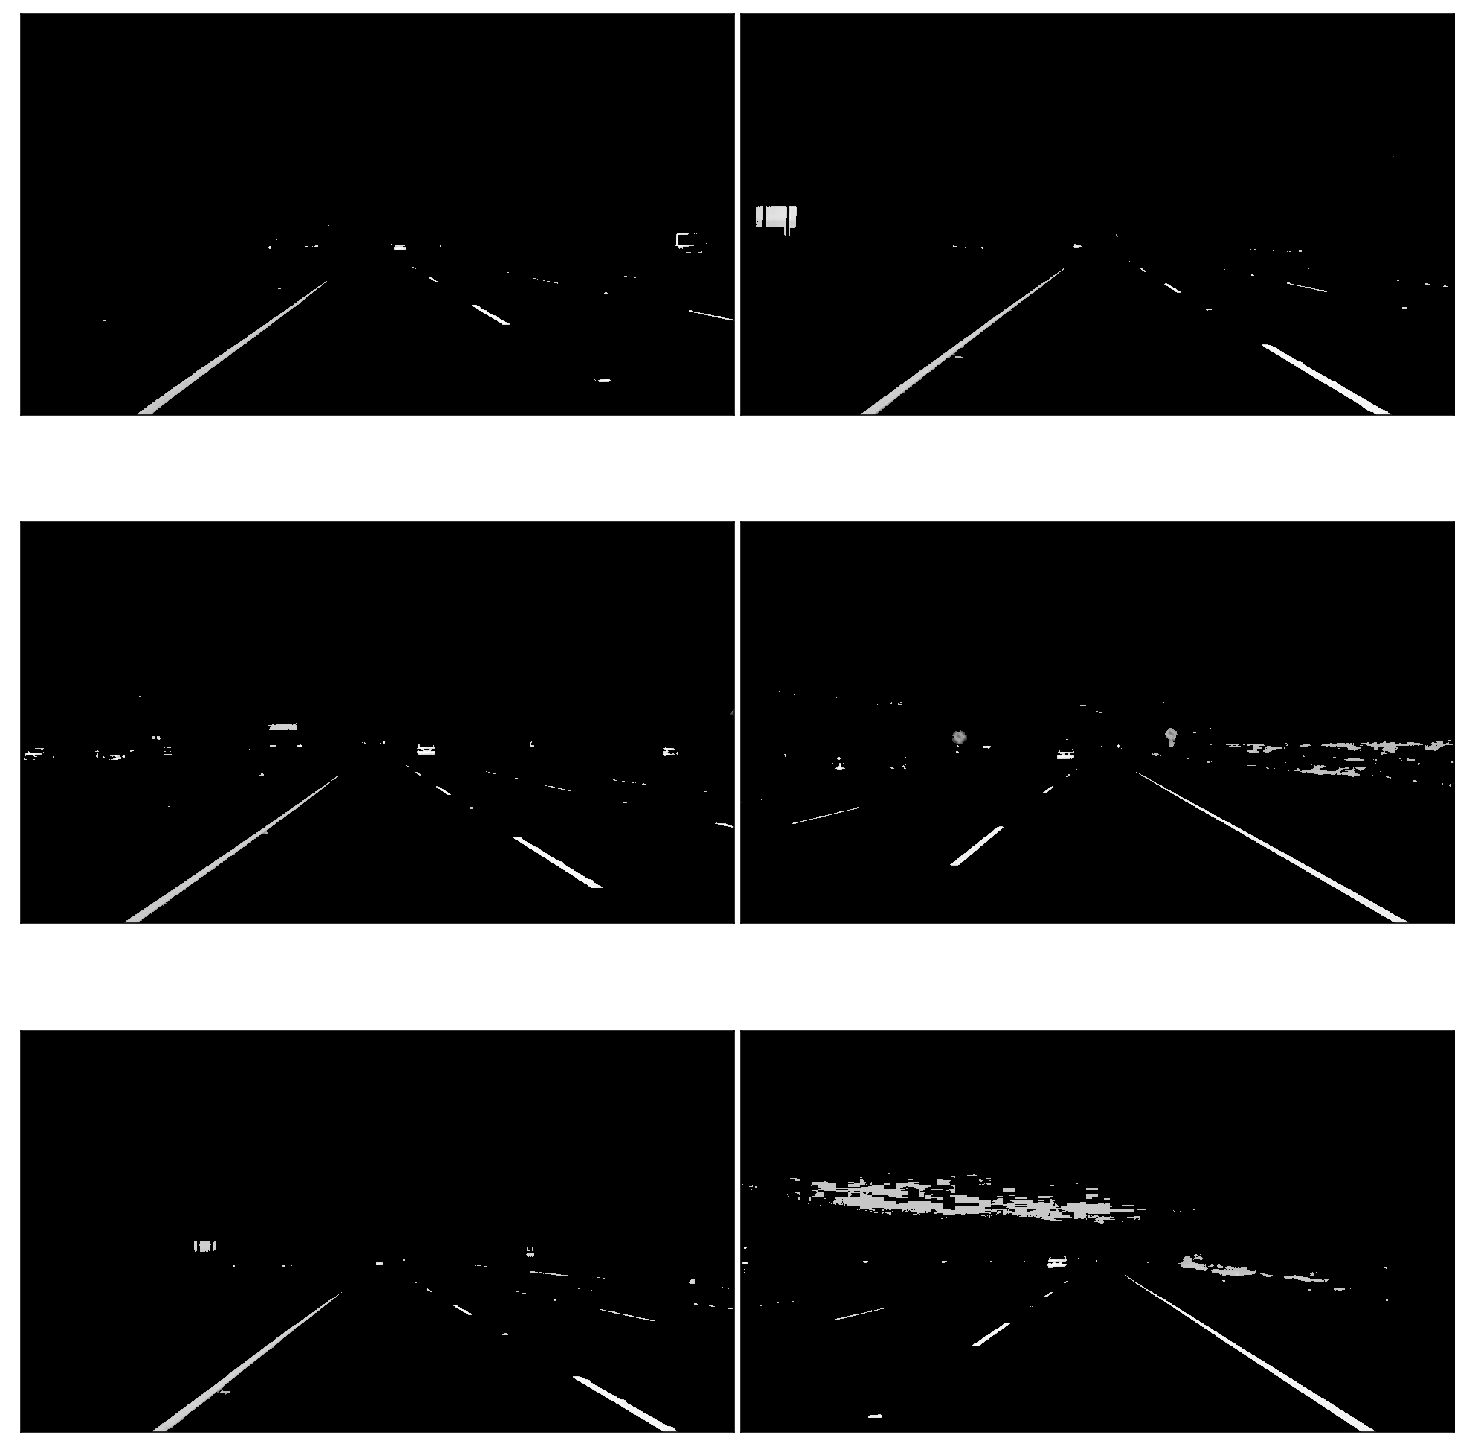

In [6]:
g_i = convert_gray_scale(w_y)
gray_images = list(map(convert_gray_scale,white_yellow_filter))
show_images(gray_images)

# Apply Smoothing

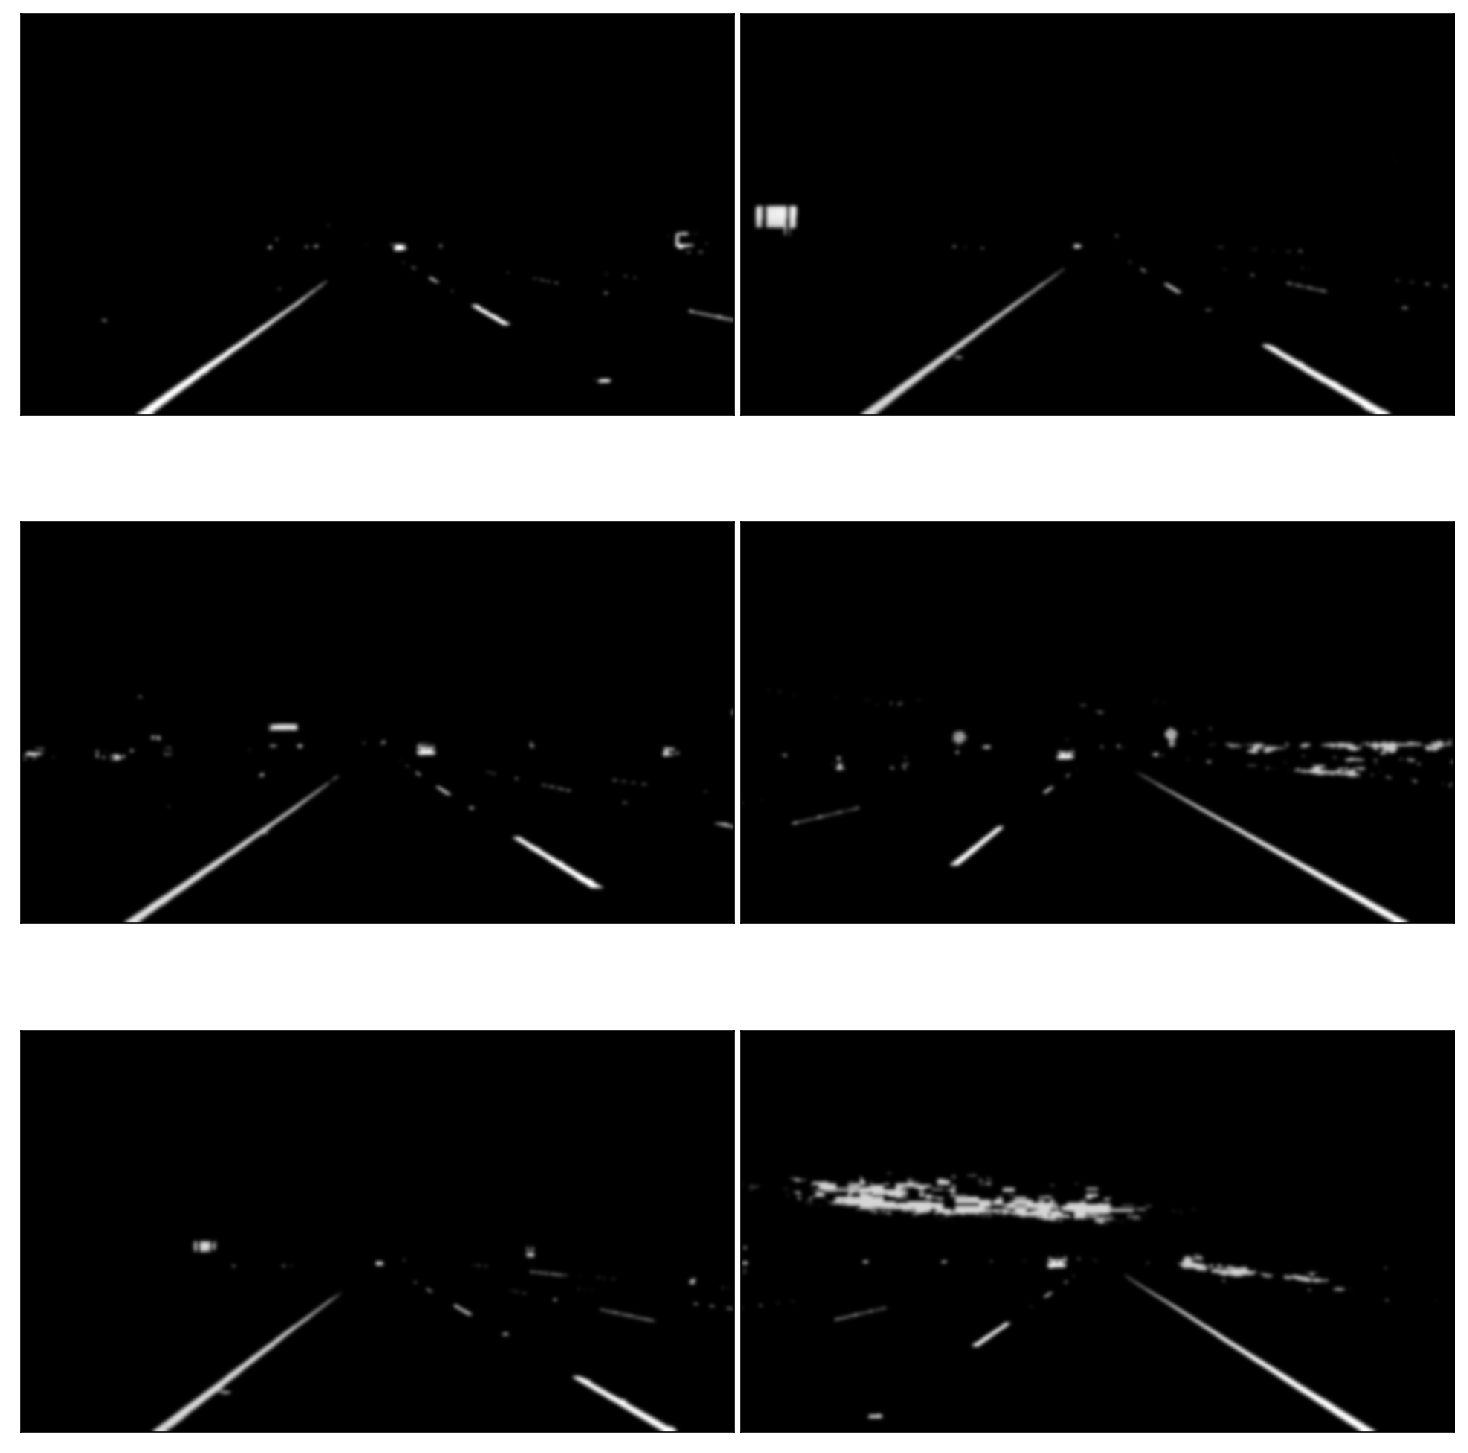

In [7]:
b_i = apply_smoothing(g_i)
blurred_images = list(map(lambda img:apply_smoothing(img),gray_images))
show_images(blurred_images)

# Detect Edges

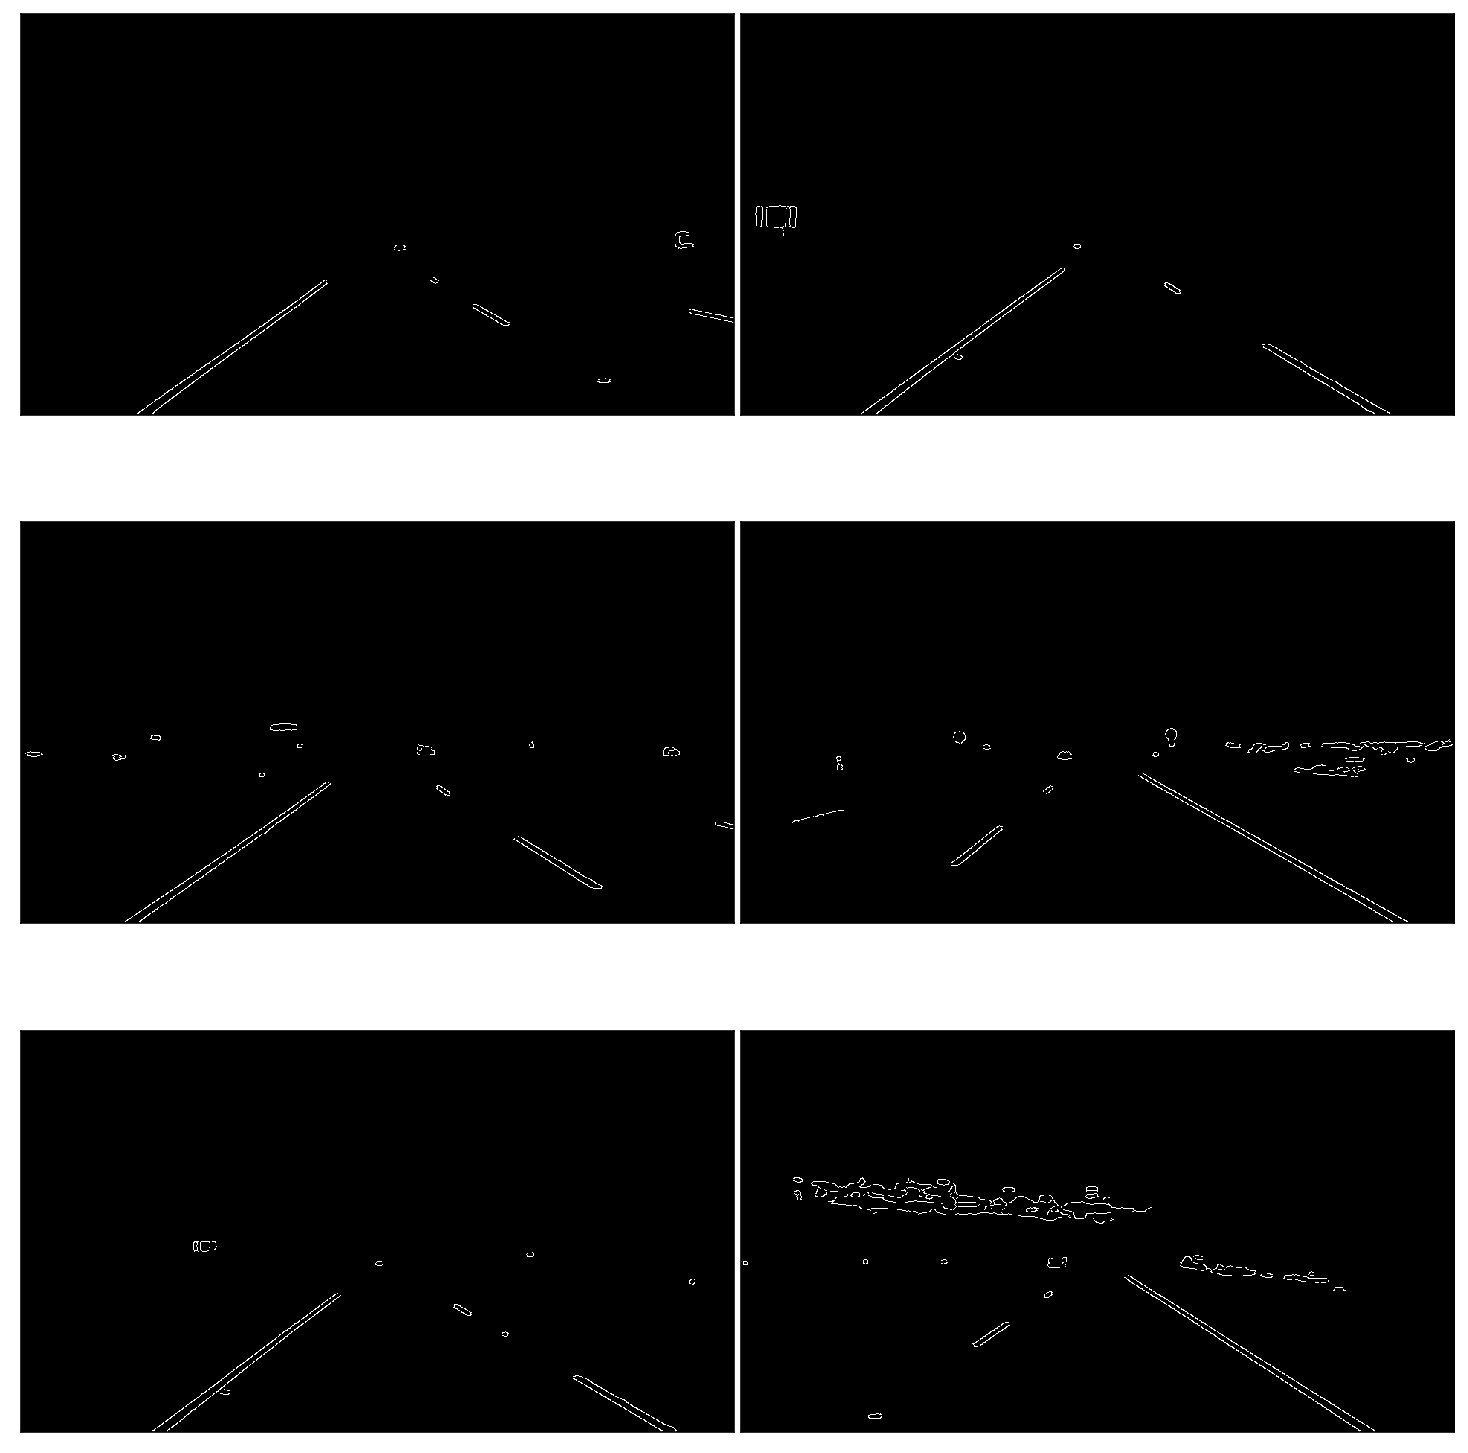

In [8]:
e_i = detect_edges(b_i)
edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

# Region of Interest selection

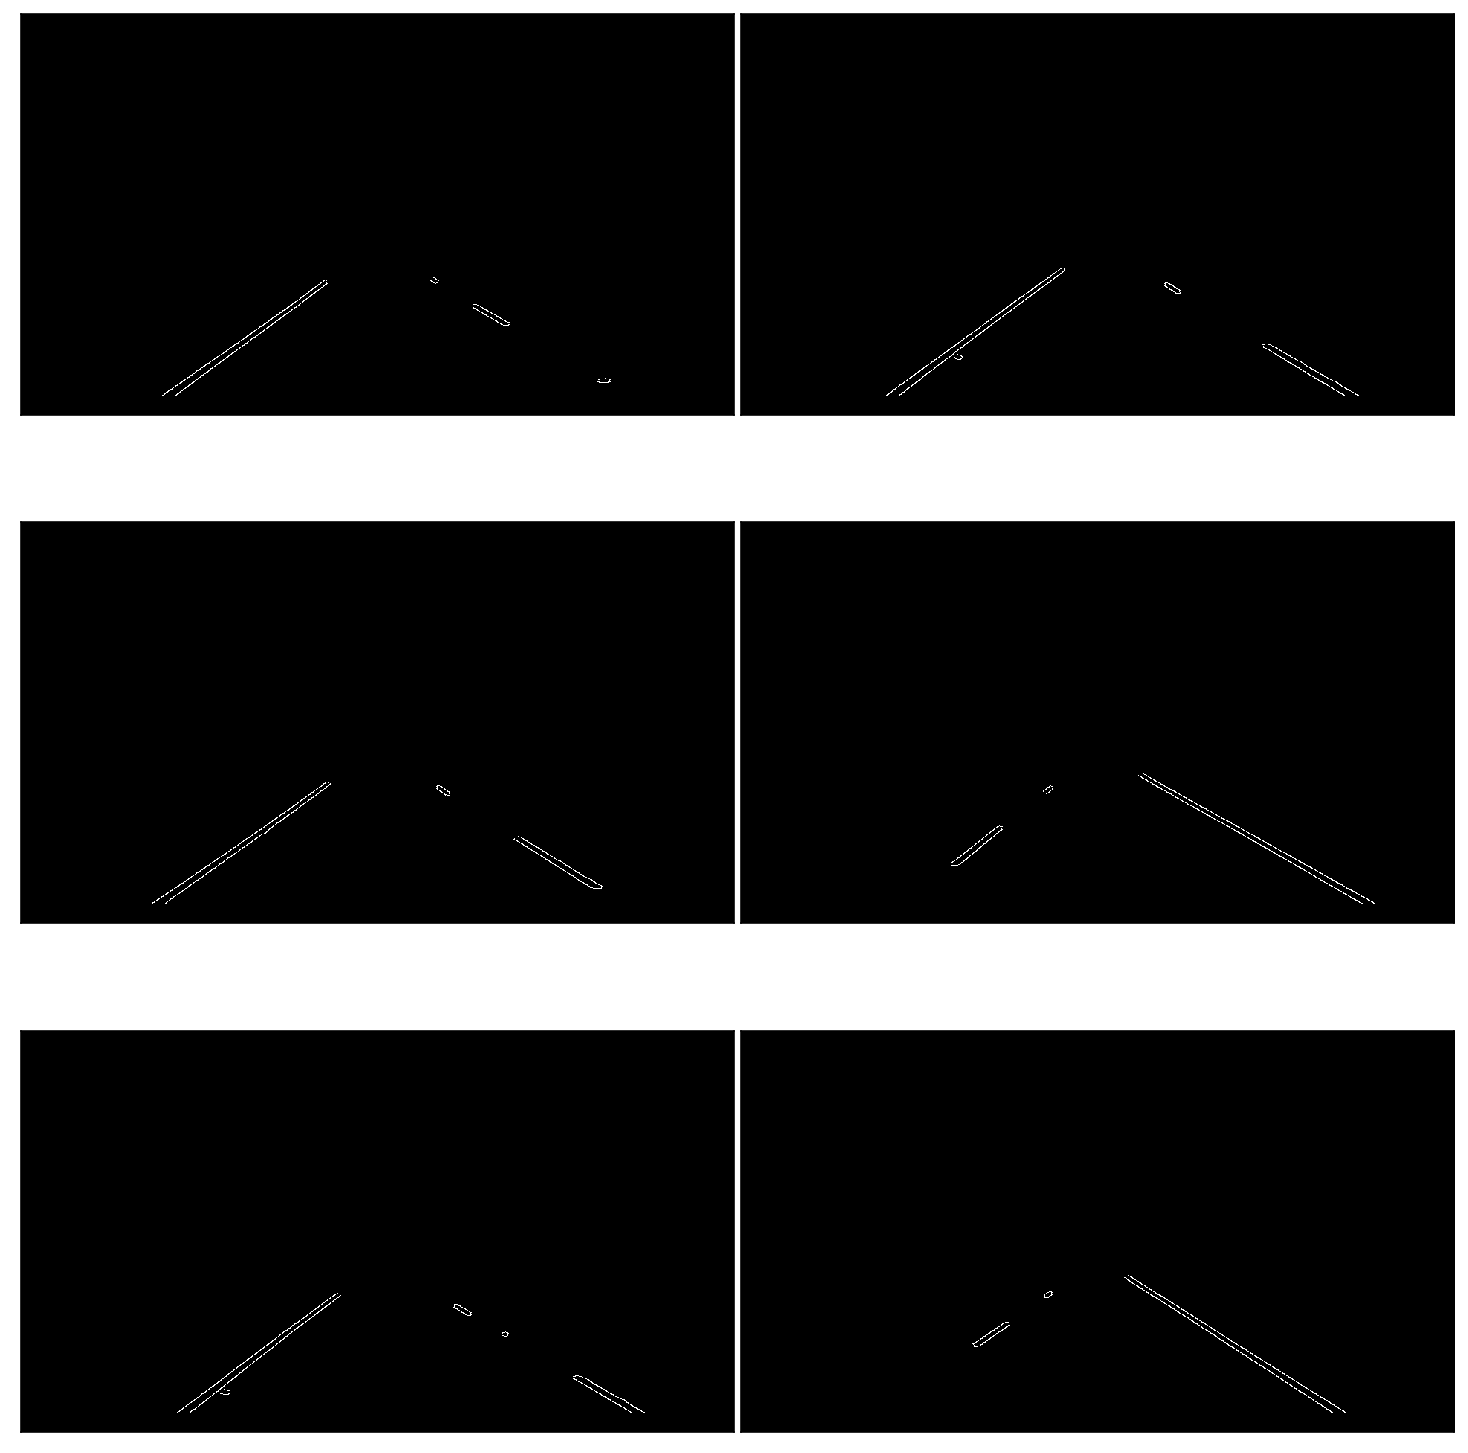

In [9]:
r_i = select_region(e_i)
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

# Apply Hough Transform

In [10]:
list_of_lines = list(map(hough_lines, roi_images))
l_o_l=hough_lines(r_i)

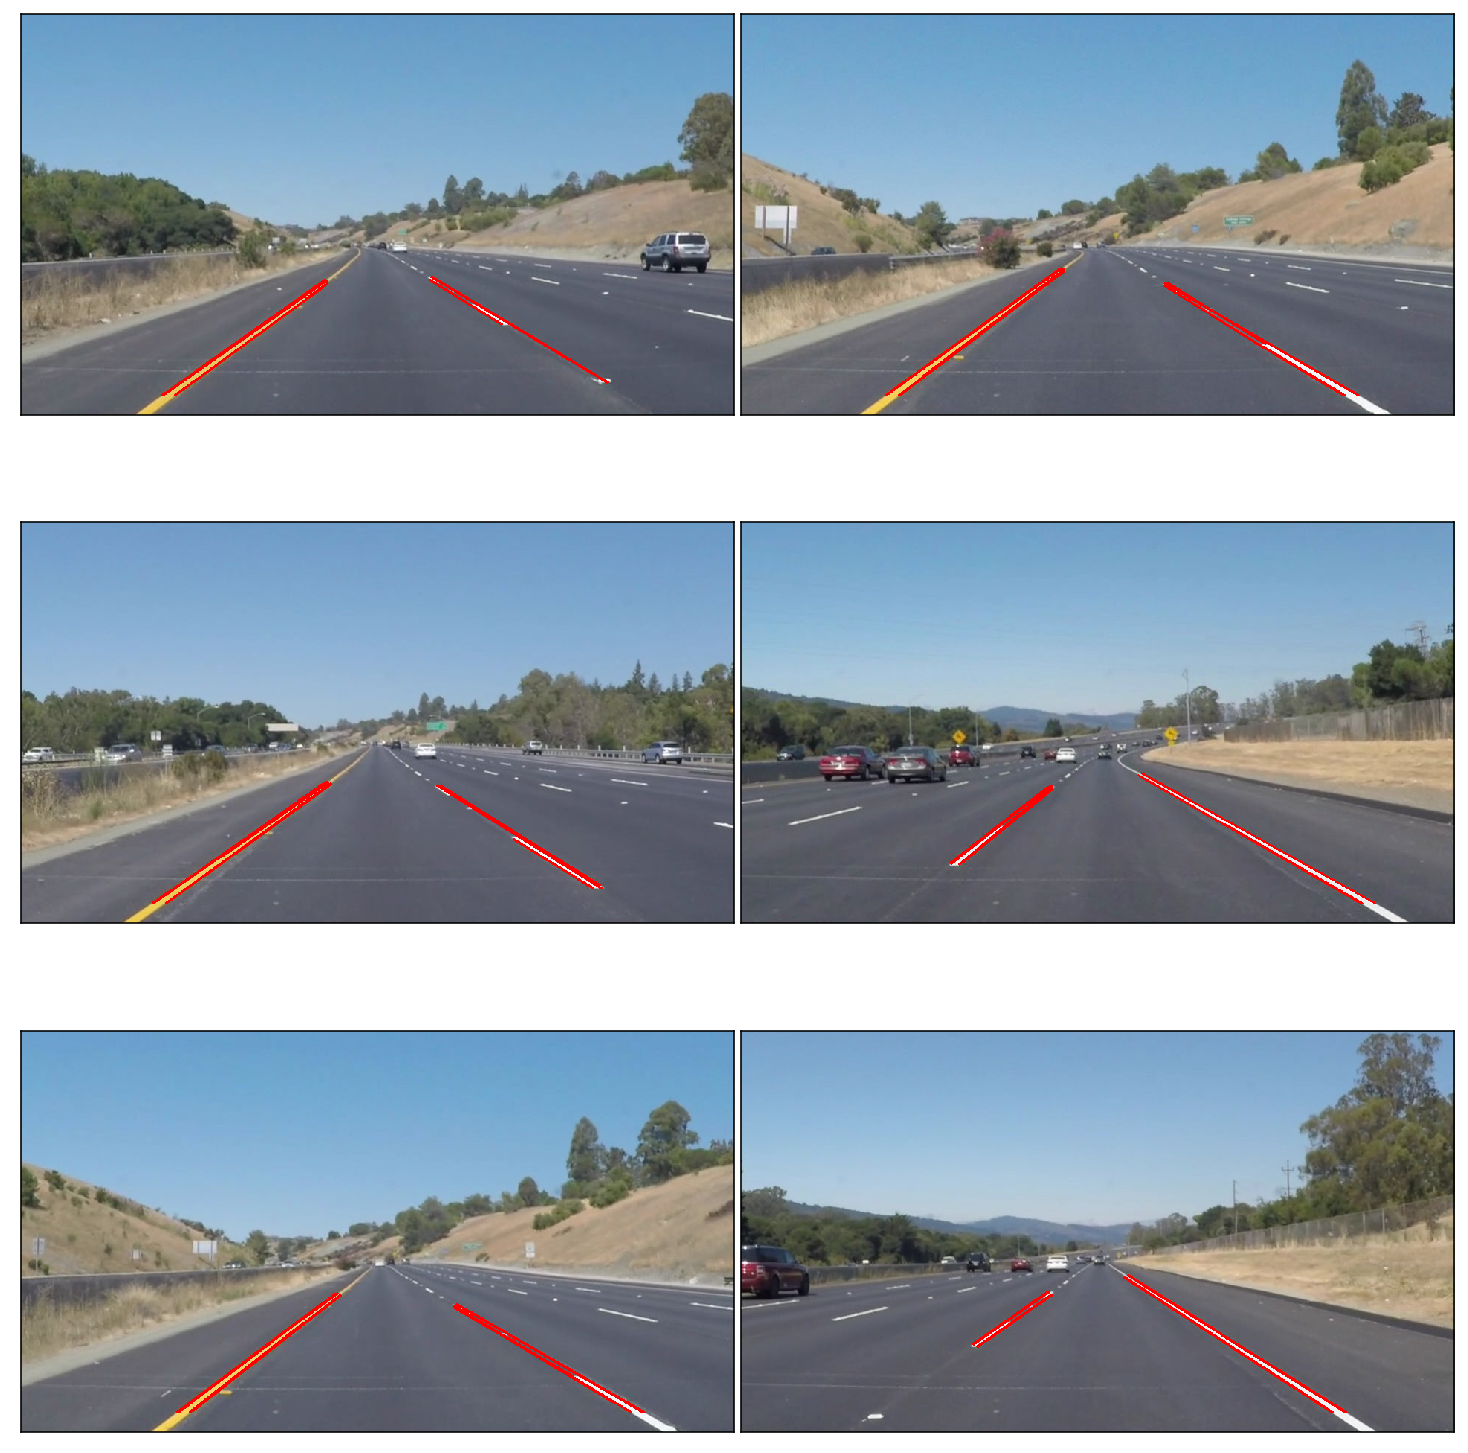

In [11]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

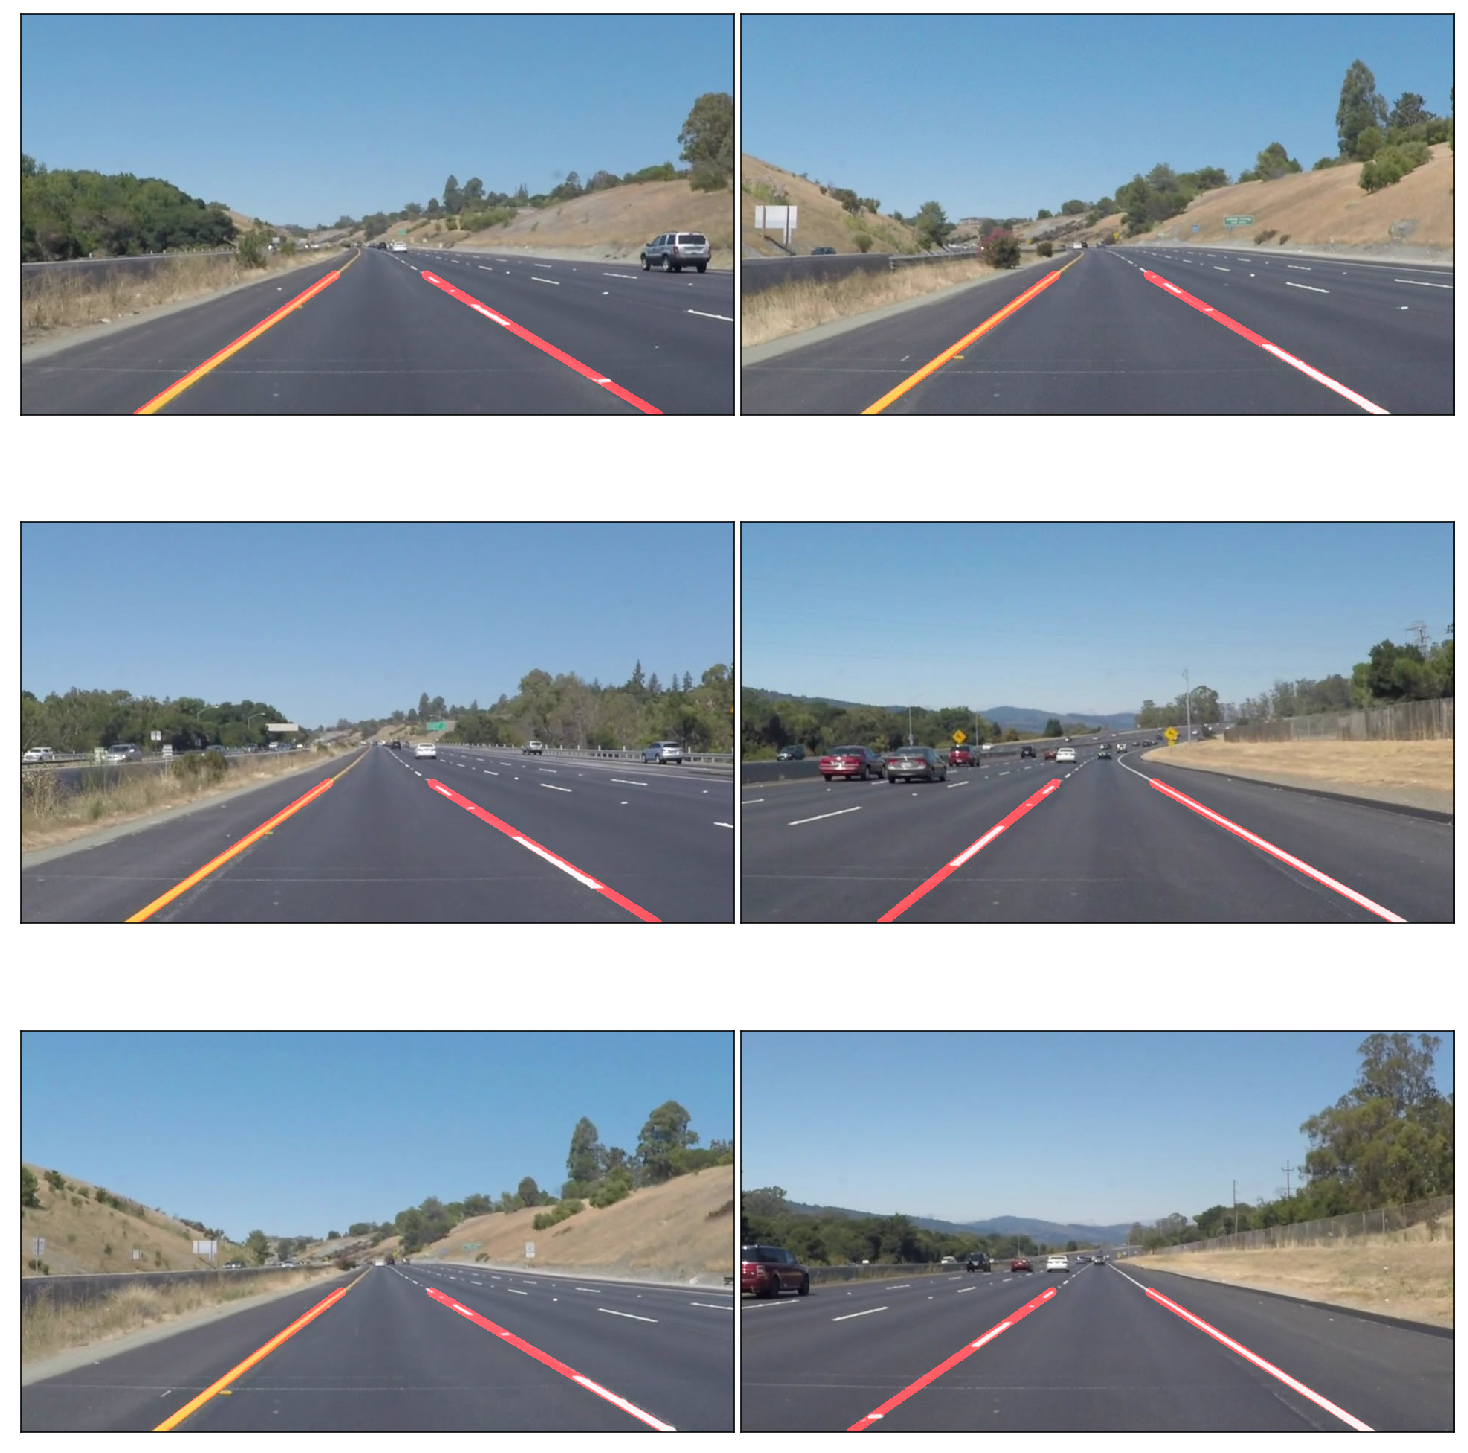

In [12]:
def draw_lines_complete(image, lines, color=[255, 0, 0], thickness=12):
    
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,color,thickness)
            
    return cv2.addWeighted(image, 1.0, line_image, 0.9, 0.0)
        
        
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lines_complete(image,lanes(image,lines)))
    
show_images(lane_images)    

In [13]:
from collections import deque
Length = 50
class LaneDetection:
    def __init__(self):
        self.left_lines = deque(maxlen=Length)
        self.right_lines = deque(maxlen=Length)
        
    def process(self,image):
        filter_colors = filter_color(image)
        grayscale = convert_gray_scale(filter_colors)
        smooth = apply_smoothing(grayscale)
        canny = detect_edges(smooth)
        regions = select_region(canny)
        hough = hough_lines(regions)
        left_lines,right_lines = lanes(image,hough)
        
        def mean_lines(line,lines):
            if line is not None:
                lines.append(line)
                
            if len(lines) > 0:
                line = np.mean(lines,axis=0,dtype=np.int32)
                line=tuple(map(tuple,line))
            return line
        
        left_lines = mean_lines(left_lines, self.left_lines)
        right_lines = mean_lines(right_lines,self.right_lines)
        
        return draw_lines_complete(image,(left_lines,right_lines))
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_video(video_input, video_output):
    detector = LaneDetection()
    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('test_videos_output', video_output), audio=False)

In [19]:
%time process_video('solidWhiteRight.mp4','white.mp4')

t:   3%|▎         | 6/221 [00:00<00:03, 57.05it/s, now=None]

Moviepy - Building video test_videos_output/white.mp4.
Moviepy - Writing video test_videos_output/white.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/white.mp4
CPU times: user 6.09 s, sys: 260 ms, total: 6.35 s
Wall time: 5.93 s


In [20]:
%time process_video('solidYellowLeft.mp4','yellow.mp4')

t:   1%|          | 5/681 [00:00<00:14, 48.12it/s, now=None]

Moviepy - Building video test_videos_output/yellow.mp4.
Moviepy - Writing video test_videos_output/yellow.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/yellow.mp4
CPU times: user 19.9 s, sys: 589 ms, total: 20.5 s
Wall time: 18.4 s


In [21]:
%time process_video('challenge.mp4','challenge.mp4')

t:   2%|▏         | 4/251 [00:00<00:06, 37.24it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 16 s, sys: 531 ms, total: 16.5 s
Wall time: 23.6 s
